# TP Chapitre 6 : Graphes et diffusion sur données (Corrigé)
Ce corrigé propose des solutions détaillées pour chaque exercice du TP sur les graphes et la diffusion sur données.

## 1. Importer les bibliothèques nécessaires

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_swiss_roll
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import pygsp
import pandas as pd

## 2. Génération et exploration d'un nuage de points

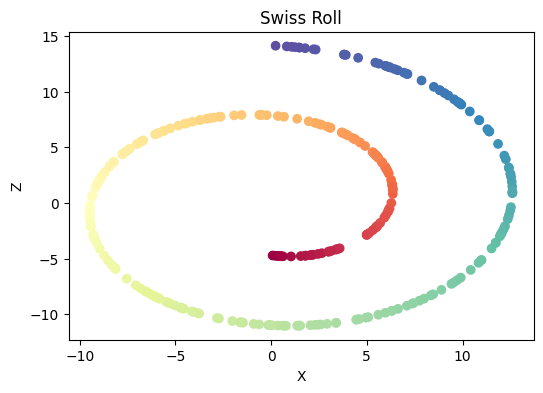

In [4]:
# Génération d'un Swiss Roll
X, t = make_swiss_roll(n_samples=300)
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,2], c=t, cmap='Spectral')
plt.title('Swiss Roll')
plt.xlabel('X')
plt.ylabel('Z')
plt.show()

## 3. Construction du graphe de voisinage

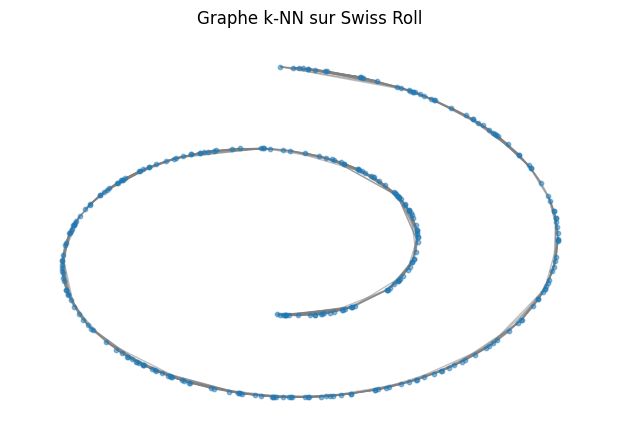

In [19]:
# Construction du graphe k-NN
k = 5
nbrs = NearestNeighbors(n_neighbors=k).fit(X)
distances, indices = nbrs.kneighbors(X)
G = nx.Graph()
for i in range(X.shape[0]):
    for j in indices[i]:
        if i != j:
            G.add_edge(i, j, weight=np.linalg.norm(X[i]-X[j]))
# Visualisation du graphe (projection 2D)
plt.figure(figsize=(6,4))
pos = {i: (X[i,0], X[i,2]) for i in range(X.shape[0])}
nx.draw(G, pos, node_size=10, edge_color='gray', alpha=0.5)
plt.title('Graphe k-NN sur Swiss Roll')
plt.show()

## 4. Calcul du Laplacien et analyse spectrale

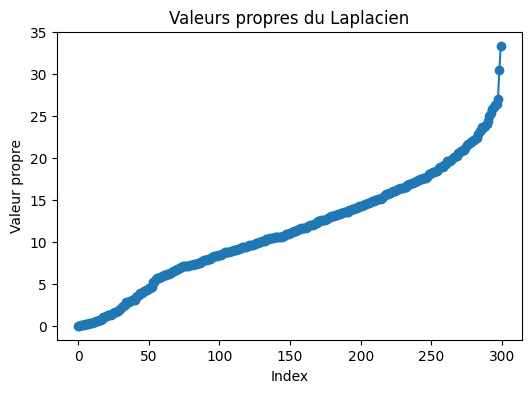

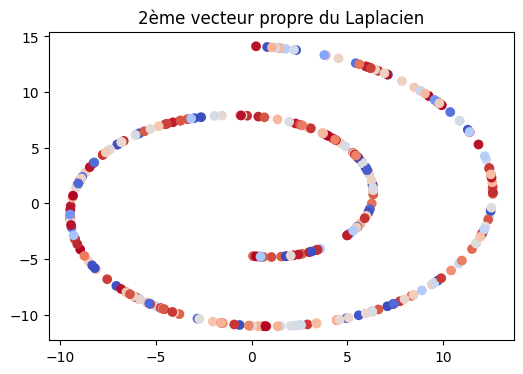

In [20]:
# Calcul du Laplacien et analyse spectrale
L = nx.laplacian_matrix(G).toarray()
eigvals, eigvecs = np.linalg.eigh(L)
plt.figure(figsize=(6,4))
plt.plot(eigvals, marker='o')
plt.title('Valeurs propres du Laplacien')
plt.xlabel('Index')
plt.ylabel('Valeur propre')
plt.show()
# Visualisation des deux premiers vecteurs propres
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,2], c=eigvecs[:,1], cmap='coolwarm')
plt.title('2ème vecteur propre du Laplacien')
plt.show()

## 5. Diffusion multi-échelle et distances de diffusion

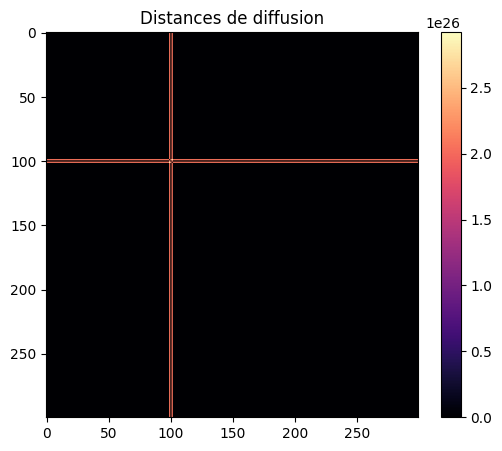

In [21]:
# Diffusion multi-échelle (noyau de chaleur)
t_param = 10
K = np.exp(-t_param * L)
# Distance de diffusion entre deux points i, j
def diffusion_distance(i, j):
    return np.linalg.norm(K[i,:] - K[j,:])
# Exemple : matrice de distances de diffusion
D_diff = np.zeros((X.shape[0], X.shape[0]))
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        D_diff[i,j] = diffusion_distance(i, j)
# Visualisation (heatmap)
plt.figure(figsize=(6,5))
plt.imshow(D_diff, cmap='magma', aspect='auto')
plt.title('Distances de diffusion')
plt.colorbar()
plt.show()

## 6. Propagation de labels et bottleneck

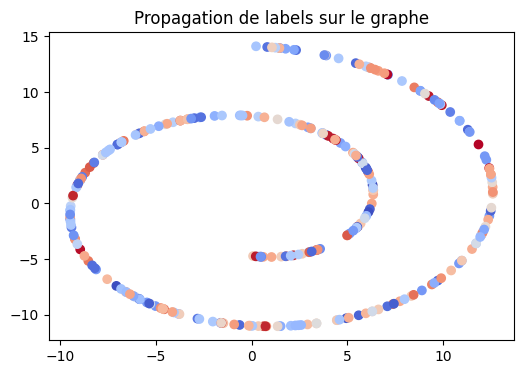

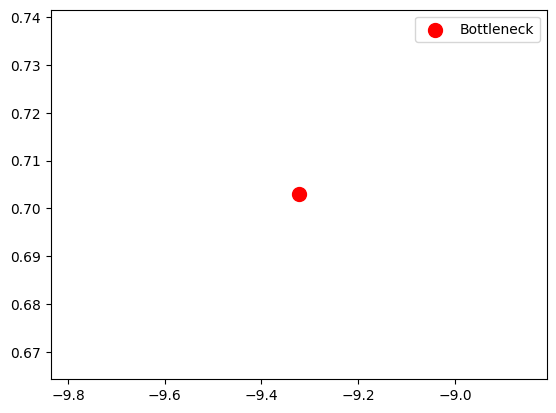

In [22]:
# Propagation de labels (Poisson discrete)
labels = np.zeros(X.shape[0])
labels[:10] = 1  # On fixe les 10 premiers points comme 'labelés'
# Résolution du système : Lx = b
b = np.zeros(X.shape[0])
b[:10] = 1
from scipy.linalg import solve
# On impose les labels sur les points fixés, on résout pour les autres
mask = labels == 0
L_sub = L[mask][:,mask]
b_sub = -L[mask][:,~mask] @ labels[~mask]
labels[mask] = solve(L_sub, b_sub)
# Visualisation
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,2], c=labels, cmap='coolwarm')
plt.title('Propagation de labels sur le graphe')
plt.show()
# Bottleneck : points avec forte variation du label
grad = np.abs(np.gradient(labels))
bottleneck_idx = np.argmax(grad)
plt.scatter(X[bottleneck_idx,0], X[bottleneck_idx,2], c='red', s=100, label='Bottleneck')
plt.legend()

## 7. Segmentation d'image par diffusion

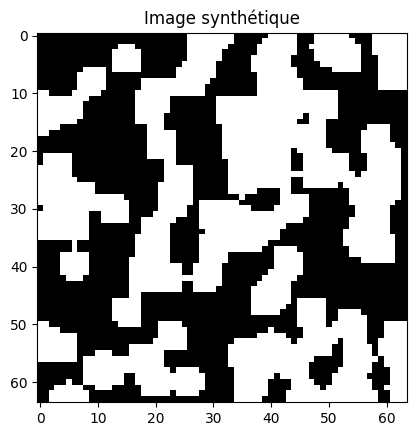

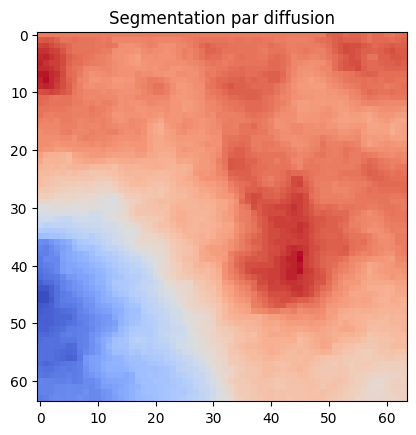

In [13]:
# Exemple de segmentation sur une image synthétique
from skimage.data import binary_blobs
from skimage.util import img_as_float
img = img_as_float(binary_blobs(length=64, n_dim=2))
plt.imshow(img, cmap='gray')
plt.title('Image synthétique')
plt.show()
# Construction du graphe des pixels
coords = np.array(np.meshgrid(np.arange(img.shape[0]), np.arange(img.shape[1]))).reshape(2,-1).T
G_img = nx.grid_2d_graph(img.shape[0], img.shape[1])
# Poids selon la similarité de couleur
for (i, j) in G_img.edges():
    G_img.edges[i, j]['weight'] = np.exp(-np.abs(img[i[0], i[1]] - img[j[0], j[1]]))
# Propagation de labels : on fixe un label sur une région
labels_img = np.zeros(img.size)
labels_img[:50] = 1
# Laplacien et propagation
L_img = nx.laplacian_matrix(G_img).toarray()
b_img = np.zeros(img.size)
b_img[:50] = 1
from scipy.linalg import solve
mask_img = labels_img == 0
L_sub_img = L_img[mask_img][:,mask_img]
b_sub_img = -L_img[mask_img][:,~mask_img] @ labels_img[~mask_img]
labels_img[mask_img] = solve(L_sub_img, b_sub_img)
# Visualisation du label propagé
plt.imshow(labels_img.reshape(img.shape), cmap='coolwarm')
plt.title('Segmentation par diffusion')
plt.show()

## 8. Applications modernes : NLP et bioinformatique

**Exemple NLP :**
On peut construire un graphe de mots où les arêtes sont pondérées par la similarité sémantique (cosinus entre embeddings). La diffusion permet d’identifier des communautés de mots ou de propager des labels (catégories, sentiments).

**Exemple bioinformatique :**
Un graphe de gènes ou protéines, arêtes pondérées par la co-expression ou interaction. La diffusion permet de détecter des modules fonctionnels ou de propager des labels (maladie, fonction).

## Comparaison k-NN vs epsilon-graph et visualisation de la matrice d'adjacence
Voyons comment le choix du graphe influence la connectivité et la diffusion sur le Swiss Roll.

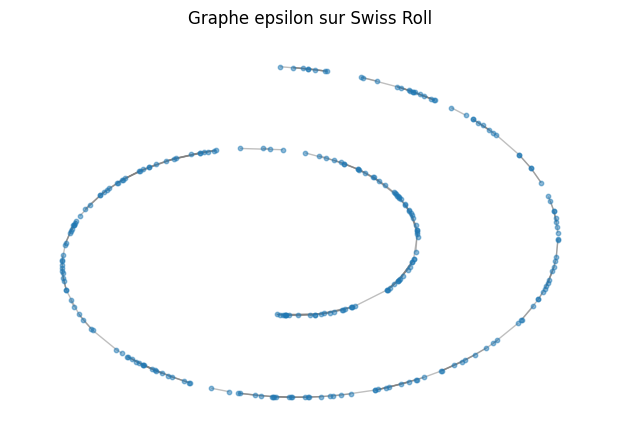

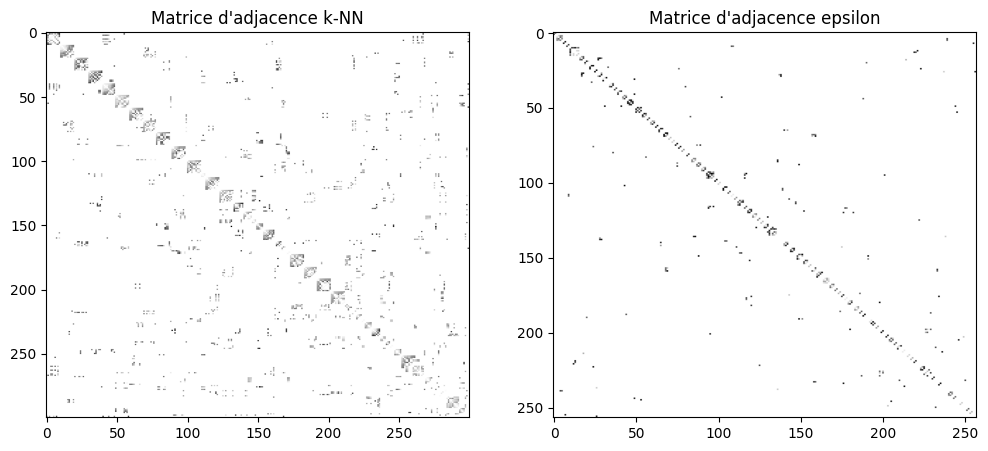

In [14]:
# Construction d'un graphe epsilon (seuil de distance)
epsilon = 2.0  # à ajuster selon la structure
G_eps = nx.Graph()
for i in range(X.shape[0]):
    for j in range(X.shape[0]):
        if i != j and np.linalg.norm(X[i]-X[j]) < epsilon:
            G_eps.add_edge(i, j, weight=np.linalg.norm(X[i]-X[j]))
# Visualisation du graphe epsilon
plt.figure(figsize=(6,4))
pos = {i: (X[i,0], X[i,2]) for i in range(X.shape[0])}
nx.draw(G_eps, pos, node_size=10, edge_color='gray', alpha=0.5)
plt.title('Graphe epsilon sur Swiss Roll')
plt.show()
# Visualisation de la matrice d'adjacence k-NN vs epsilon
A_knn = nx.to_numpy_array(G)
A_eps = nx.to_numpy_array(G_eps)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(A_knn, cmap='Greys', aspect='auto')
plt.title('Matrice d\'adjacence k-NN')
plt.subplot(1,2,2)
plt.imshow(A_eps, cmap='Greys', aspect='auto')
plt.title('Matrice d\'adjacence epsilon')
plt.show()

## Visualisation du 2ème vecteur propre du Laplacien pour le graphe epsilon

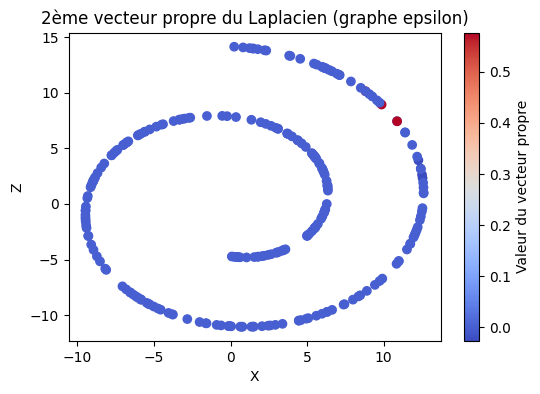

In [16]:
# Calcul du Laplacien et spectre pour le graphe epsilon
L_eps = nx.laplacian_matrix(G_eps).toarray()
eigvals_eps, eigvecs_eps = np.linalg.eigh(L_eps)
plt.figure(figsize=(6,4))
nodes_eps = list(G_eps.nodes)
plt.scatter(X[nodes_eps,0], X[nodes_eps,2], c=eigvecs_eps[:,1], cmap='coolwarm')
plt.title('2ème vecteur propre du Laplacien (graphe epsilon)')
plt.xlabel('X')
plt.ylabel('Z')
plt.colorbar(label='Valeur du vecteur propre')
plt.show()

## Analyse automatique de la connectivité et visualisation du 2ème vecteur propre pour différents epsilon

/tmp/ipykernel_3876209/2812957664.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


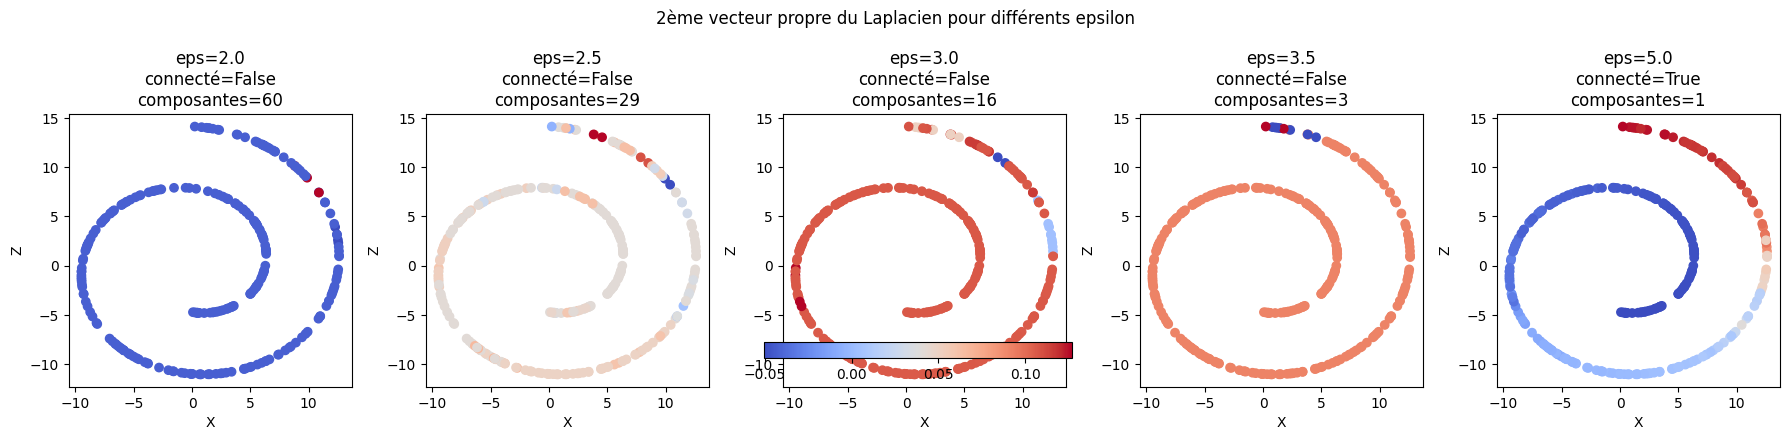

In [18]:
import networkx as nx
epsilons = [2.0, 2.5, 3.0, 3.5, 5.0]
fig, axes = plt.subplots(1, len(epsilons), figsize=(18,4))
for idx, epsilon in enumerate(epsilons):
    G_eps = nx.Graph()
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            if i != j and np.linalg.norm(X[i]-X[j]) < epsilon:
                G_eps.add_edge(i, j, weight=np.linalg.norm(X[i]-X[j]))
    connected = nx.is_connected(G_eps)
    n_comp = nx.number_connected_components(G_eps)
    L_eps = nx.laplacian_matrix(G_eps).toarray()
    eigvals_eps, eigvecs_eps = np.linalg.eigh(L_eps)
    nodes_eps = list(G_eps.nodes)
    sc = axes[idx].scatter(X[nodes_eps,0], X[nodes_eps,2], c=eigvecs_eps[:,1], cmap='coolwarm')
    axes[idx].set_title(f'eps={epsilon}\nconnecté={connected}\ncomposantes={n_comp}')
    axes[idx].set_xlabel('X')
    axes[idx].set_ylabel('Z')
fig.colorbar(sc, ax=axes, orientation='horizontal', fraction=0.05)
plt.suptitle('2ème vecteur propre du Laplacien pour différents epsilon')
plt.tight_layout()
plt.show()